In [1]:
def scale_negexp(x, q=.95):
    x = x / np.quantile(x,q=q)
    return np.exp(-x) 

In [14]:
%load_ext autoreload
%autoreload 2
from yahpo_train.model  import *
from yahpo_train.metrics import *
from yahpo_train.cont_scalers import *
from yahpo_gym.configuration import cfg, config_dict, Configuration
from yahpo_gym.benchmarks import lcbench, rbv2, nasbench_301, fcnet, taskset
from functools import partial
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
v = Configuration(config_dict.configs['lcbench'])
"\n{:<10} {:<10} {:<10} {:<10} {:<10}".format("lcbench", len(v.instance_names), len(v.cat_names), len(v.cat_names), len(v.y_names))

'\nlcbench    14         1          1          6         '

In [23]:
out = ""   
for k in config_dict.configs.keys():
    v = config_dict.get_item(k)
    print(k)
    out += "\n{:<10} {:<10} {:<10} {:<10} {:<10}".format(k, len(v.instance_names), len(v.cat_names), len(v.cat_names), len(v.y_names))

TypeError: object of type 'NoneType' has no len()

array([[<AxesSubplot:title={'center':'Associative_GRU128_BS128_Pairs10_Tokens50'}>,
        <AxesSubplot:title={'center':'Associative_GRU256_BS128_Pairs20_Tokens50'}>,
        <AxesSubplot:title={'center':'Associative_LSTM128_BS128_Pairs10_Tokens50'}>,
        <AxesSubplot:title={'center':'Associative_LSTM128_BS128_Pairs20_Tokens50'}>],
       [<AxesSubplot:title={'center':'Associative_LSTM128_BS128_Pairs5_Tokens20'}>,
        <AxesSubplot:title={'center':'Associative_LSTM256_BS128_Pairs20_Tokens50'}>,
        <AxesSubplot:title={'center':'Associative_LSTM256_BS128_Pairs40_Tokens100'}>,
        <AxesSubplot:title={'center':'Associative_VRNN128_BS128_Pairs10_Tokens50'}>],
       [<AxesSubplot:title={'center':'Associative_VRNN256_BS128_Pairs20_Tokens50'}>,
        <AxesSubplot:title={'center':'Copy_GRU128_BS128_Length20_Tokens10'}>,
        <AxesSubplot:title={'center':'Copy_GRU256_BS128_Length40_Tokens50'}>,
        <AxesSubplot:title={'center':'Copy_LSTM128_BS128_Length20_Tokens10'}>],

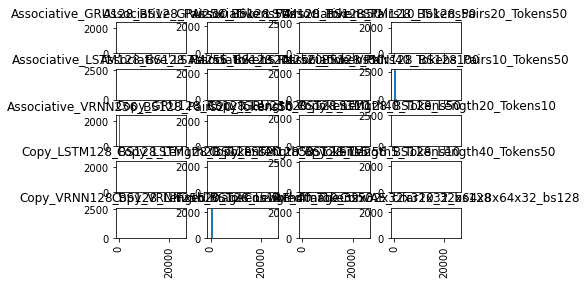

In [34]:
df[['train', 'task_name']].hist(bins=30, by='task_name', sharex=True)

array([[<AxesSubplot:title={'center':'train_scaled'}>]], dtype=object)

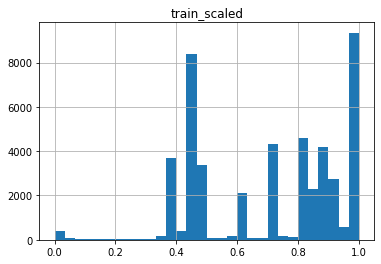

In [63]:
df['train_scaled'] = df.groupby('task_name')['train'].apply(scale_negexp, q=.98)
df[['train_scaled','task_name']].hist(bins=30)

In [18]:
    # Transforms
    tfms = {}
    [tfms.update({k:ContTransformerRange}) for k in ["mmce", "f1", "auc", "logloss"]]
    [tfms.update({k:partial(ContTransformerLogRange, logfun=torch.log10, expfun=float_pow10)}) for k in ["timetrain", "timepredict", "cost", "gamma"]]
    # [tfms.update({k:ContTransformerNegExpRange}) for k in ["logloss"]]
    embds_dbl = [tfms.get(name) if tfms.get(name) is not None else ContTransformerNone for name, cont in dls.all_cols[dls.cont_names].iteritems()]
    embds_tgt = [tfms.get(name) if tfms.get(name) is not None else ContTransformerNone for name, cont in dls.ys.iteritems()]
    f = FFSurrogateModel(dls, layers=[512,512], embds_dbl=embds_dbl, embds_tgt=embds_tgt)
    l = SurrogateTabularLearner(dls, f, loss_func=nn.MSELoss(reduction='mean'), metrics=nn.MSELoss)
    l.metrics = [AvgTfedMetric(mae),  AvgTfedMetric(r2), AvgTfedMetric(spearman)]
    l.add_cb(MixHandler)
    l.add_cb(EarlyStoppingCallback(patience=3))

Sequential(
  (0): LinBnDrop(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=56, out_features=512, bias=True)
    (2): SELU(inplace=True)
  )
  (1): LinBnDrop(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): SELU(inplace=True)
  )
  (2): LinBnDrop(
    (0): Linear(in_features=512, out_features=6, bias=True)
  )
) 
 Sequential(
  (0): Linear(in_features=56, out_features=6, bias=True)
)

In [23]:
l.ps

AttributeError: 'FFSurrogateModel' object has no attribute 'ps'

In [206]:
l.fit_flat_cos(1, 1e-3)
# for p in l.model.wide.parameters():
#     p.requires_grad = False
# l.fit_flat_cos(5, 1e-4)

epoch,train_loss,valid_loss,mae,r2,spearman,time
0,0.005582,0.006284,[5.45339249e-02 2.93688303e-02 5.83040791e-02 4.69076813e-01 3.91783514e+01 1.53160106e+01],[ 8.08837302e-01 9.56170125e-01 8.75917598e-01 6.77835084e-01 -4.41387222e+01 -8.83855804e+04],[ 0.88737381 nan nan 0.79986789 -0.01366044 -0.91835903],01:21


C:\Users\flo\AppData\Local\r-miniconda\envs\yahpo\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [223]:
l.recorder.dls.y_names

(#6) ['mmce','f1','auc','logloss','timetrain','timepredict']

AttributeError: 'FFSurrogateModel' object has no attribute 'device'

In [30]:
for e in l.embds_tgt:
    for p in e.parameters():
        print(p)

In [ ]:
l.export_onnx(cfg)

c:\Users\flo\Documents\yahpo_gym\yahpo_train\yahpo_train\cont_normalization.py:50: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if torch.abs(lmbda) < self.eps:
c:\Users\flo\Documents\yahpo_gym\yahpo_train\yahpo_train\cont_normalization.py:56: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if torch.abs(lmbda - 2.) <= self.eps:
c:\Users\flo\Documents\yahpo_gym\yahpo_train\yahpo_train\model.py:138: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value wil

In [ ]:
 class Scaler():
    def  __init__(self, forward, invert):
        self.fwd = forward
        self.inv = invert

    def forward(self, x):
            return self.fwd(x)

    def invert(self,x):
        return self.inv(x)

 scs = [Scaler(torch.log1p, torch.expm1), Scaler(torch.log10, lambda x: torch.pow(10., x)),Scaler(torch.log2, torch.exp2), Scaler(lambda x: torch.exp(-x), lambda x: - torch.log(x))]

In [ ]:
x= torch.rand(100)
for sc in scs:
    fwd = sc.forward(x)
    print(torch.mean(sc.invert(fwd) - x))

tensor(-4.3213e-09)
tensor(-7.3342e-10)
tensor(-1.9278e-09)
tensor(-3.3295e-10)


In [64]:
config = cfg('nb301')

In [72]:
dtypes = dict(zip(config.cat_names, ["object"] * len(config.cat_names)))
df = pd.read_csv(config.get_path("dataset"), skipinitialspace=True,dtype=dtypes).sample(frac=1.).reset_index()
df.reindex(columns=config.cat_names+config.cont_names+config.y_names)

,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_0,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_1,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_2,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_3,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_4,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_5,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_6,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_7,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_8,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_9,...,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_reduce_13,NetworkSelectorDatasetInfo_COLON_darts_COLON_inputs_node_normal_3,NetworkSelectorDatasetInfo_COLON_darts_COLON_inputs_node_normal_4,NetworkSelectorDatasetInfo_COLON_darts_COLON_inputs_node_normal_5,NetworkSelectorDatasetInfo_COLON_darts_COLON_inputs_node_reduce_3,NetworkSelectorDatasetInfo_COLON_darts_COLON_inputs_node_reduce_4,NetworkSelectorDatasetInfo_COLON_darts_COLON_inputs_node_reduce_5,epoch,val_accuracy,runtime
0,max_pool_3x3,skip_connect,NaN,dil_conv_5x5,avg_pool_3x3,sep_conv_5x5,NaN,dil_conv_3x3,NaN,NaN,...,NaN,1_2,0_2,2_4,0_1,0_2,0_2,88,93.330002,3674.137015
1,sep_conv_3x3,skip_connect,sep_conv_3x3,sep_conv_3x3,NaN,sep_conv_5x5,NaN,NaN,skip_connect,sep_conv_3x3,...,dil_conv_5x5,0_1,0_3,0_1,1_2,1_2,3_4,78,93.500000,4745.371580
2,max_pool_3x3,skip_connect,NaN,avg_pool_3x3,max_pool_3x3,skip_connect,NaN,dil_conv_3x3,NaN,NaN,...,NaN,1_2,0_2,1_4,1_2,0_1,0_2,16,77.790001,503.922702
3,avg_pool_3x3,max_pool_3x3,avg_pool_3x3,dil_conv_3x3,NaN,sep_conv_5x5,dil_conv_5x5,NaN,NaN,NaN,...,NaN,0_1,0_1,1_4,0_1,0_3,1_2,6,68.650002,435.127153
4,skip_connect,sep_conv_3x3,sep_conv_5x5,NaN,skip_connect,dil_conv_5x5,NaN,sep_conv_3x3,NaN,sep_conv_5x5,...,sep_conv_3x3,0_2,0_2,0_2,1_2,1_2,3_4,45,88.000000,2681.869764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578137,avg_pool_3x3,max_pool_3x3,dil_conv_5x5,NaN,dil_conv_5x5,NaN,skip_connect,avg_pool_3x3,NaN,NaN,...,sep_conv_3x3,0_2,1_2,2_3,1_2,0_1,3_4,41,86.120003,2793.088197
5578138,skip_connect,avg_pool_3x3,NaN,dil_conv_3x3,sep_conv_3x3,sep_conv_3x3,NaN,avg_pool_3x3,NaN,NaN,...,sep_conv_5x5,1_2,0_2,1_2,0_1,0_3,2_4,64,91.510002,3123.975560
5578139,dil_conv_3x3,avg_pool_3x3,sep_conv_3x3,dil_conv_5x5,NaN,NaN,max_pool_3x3,max_pool_3x3,NaN,dil_conv_3x3,...,skip_connect,0_1,1_2,0_2,0_2,0_1,2_4,35,85.650002,2568.526061
5578140,dil_conv_3x3,dil_conv_3x3,avg_pool_3x3,NaN,dil_conv_3x3,max_pool_3x3,sep_conv_5x5,NaN,NaN,avg_pool_3x3,...,sep_conv_5x5,0_2,0_1,0_2,0_2,1_2,1_4,26,83.180000,2038.929027


In [73]:
hpars = config.cont_names+config.cat_names
[hpars.remove(fp) for fp in config.fidelity_params]
tdf =df

In [92]:
df = tdf
df

,index,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_0,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_1,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_3,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_4,NetworkSelectorDatasetInfo_COLON_darts_COLON_inputs_node_normal_3,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_5,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_6,NetworkSelectorDatasetInfo_COLON_darts_COLON_inputs_node_normal_4,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_9,...,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_reduce_10,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_reduce_11,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_reduce_12,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_reduce_4,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_reduce_5,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_reduce_7,epoch,val_accuracy,runtime,method
0,1997634,max_pool_3x3,skip_connect,dil_conv_5x5,avg_pool_3x3,1_2,sep_conv_5x5,NaN,0_2,NaN,...,NaN,sep_conv_5x5,NaN,NaN,avg_pool_3x3,skip_connect,88,93.330002,3674.137015,local_search
1,2340360,sep_conv_3x3,skip_connect,sep_conv_3x3,NaN,0_1,sep_conv_5x5,NaN,0_3,sep_conv_3x3,...,NaN,NaN,sep_conv_5x5,dil_conv_5x5,NaN,sep_conv_3x3,78,93.500000,4745.371580,pc_darts
2,5365788,max_pool_3x3,skip_connect,avg_pool_3x3,max_pool_3x3,1_2,skip_connect,NaN,0_2,NaN,...,NaN,dil_conv_5x5,NaN,dil_conv_5x5,dil_conv_5x5,NaN,16,77.790001,503.922702,tpe
3,3816716,avg_pool_3x3,max_pool_3x3,dil_conv_3x3,NaN,0_1,sep_conv_5x5,dil_conv_5x5,0_1,NaN,...,dil_conv_3x3,sep_conv_3x3,NaN,NaN,dil_conv_3x3,NaN,6,68.650002,435.127153,rs
4,2304949,skip_connect,sep_conv_3x3,NaN,skip_connect,0_2,dil_conv_5x5,NaN,0_2,sep_conv_5x5,...,NaN,NaN,max_pool_3x3,sep_conv_5x5,NaN,max_pool_3x3,45,88.000000,2681.869764,pc_darts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578137,1511262,avg_pool_3x3,max_pool_3x3,NaN,dil_conv_5x5,0_2,NaN,skip_connect,1_2,NaN,...,NaN,NaN,skip_connect,skip_connect,avg_pool_3x3,NaN,41,86.120003,2793.088197,de_multi_seed
5578138,1265207,skip_connect,avg_pool_3x3,dil_conv_3x3,sep_conv_3x3,1_2,sep_conv_3x3,NaN,0_2,NaN,...,NaN,skip_connect,NaN,NaN,dil_conv_5x5,NaN,64,91.510002,3123.975560,de
5578139,4406578,dil_conv_3x3,avg_pool_3x3,dil_conv_5x5,NaN,0_1,NaN,max_pool_3x3,1_2,dil_conv_3x3,...,NaN,sep_conv_5x5,NaN,dil_conv_3x3,skip_connect,NaN,35,85.650002,2568.526061,rs
5578140,4174603,dil_conv_3x3,dil_conv_3x3,NaN,dil_conv_3x3,0_2,max_pool_3x3,sep_conv_5x5,0_1,avg_pool_3x3,...,sep_conv_3x3,NaN,NaN,max_pool_3x3,NaN,skip_connect,26,83.180000,2038.929027,rs


In [93]:
cont_hpars = set(hpars).intersection(set(config.cat_names))
df = df[hpars].copy()
df[cont_hpars].fillna('_NA_')
df = df.apply(lambda x: pd.factorize(x.astype('category'))[0], axis=0)

In [94]:
frac = 0.1
idx = pd.Int64Index([])
for _, dfg in df.groupby(hpars):
    # Sample index blocks
    if random.random() <= frac:
        idx = idx.append(dfg.index)
print(len(idx))

557135


In [81]:
set(hpars).intersection(set(config.cat_names))

{'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_0',
 'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_1',
 'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_10',
 'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_11',
 'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_12',
 'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_13',
 'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_2',
 'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_3',
 'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_4',
 'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_5',
 'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_6',
 'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_7',
 'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_8',
 'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_9',
 'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_reduce_0',
 'NetworkSelectorDatasetInfo_COLON_darts_COLON_edge

In [63]:
df

,index,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_0,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_1,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_3,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_4,NetworkSelectorDatasetInfo_COLON_darts_COLON_inputs_node_normal_3,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_5,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_6,NetworkSelectorDatasetInfo_COLON_darts_COLON_inputs_node_normal_4,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_normal_9,...,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_reduce_10,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_reduce_11,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_reduce_12,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_reduce_4,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_reduce_5,NetworkSelectorDatasetInfo_COLON_darts_COLON_edge_reduce_7,epoch,val_accuracy,runtime,method
0,5438020,max_pool_3x3,max_pool_3x3,avg_pool_3x3,NaN,0_1,NaN,NaN,2_3,avg_pool_3x3,...,dil_conv_3x3,avg_pool_3x3,NaN,NaN,NaN,max_pool_3x3,11,68.040001,376.330933,tpe
1,2614370,dil_conv_5x5,skip_connect,NaN,sep_conv_3x3,0_2,skip_connect,NaN,0_2,NaN,...,NaN,skip_connect,NaN,sep_conv_5x5,NaN,max_pool_3x3,31,86.230003,2279.699951,re
2,879789,sep_conv_3x3,sep_conv_3x3,sep_conv_5x5,NaN,0_1,NaN,avg_pool_3x3,1_2,NaN,...,NaN,NaN,NaN,NaN,avg_pool_3x3,NaN,78,93.370003,4073.718994,de
3,3720181,sep_conv_3x3,sep_conv_5x5,NaN,dil_conv_5x5,0_2,sep_conv_5x5,NaN,0_2,NaN,...,avg_pool_3x3,NaN,NaN,sep_conv_3x3,skip_connect,skip_connect,1,39.490002,94.272499,rs
4,4983633,max_pool_3x3,skip_connect,sep_conv_3x3,sep_conv_3x3,1_2,NaN,NaN,2_3,NaN,...,dil_conv_5x5,NaN,NaN,avg_pool_3x3,sep_conv_3x3,sep_conv_3x3,56,89.570000,2668.065430,tpe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578137,3047132,sep_conv_3x3,skip_connect,NaN,dil_conv_3x3,0_2,dil_conv_3x3,skip_connect,0_1,dil_conv_5x5,...,NaN,skip_connect,NaN,sep_conv_5x5,max_pool_3x3,sep_conv_3x3,4,62.450001,187.765411,rs
5578138,3773165,sep_conv_5x5,sep_conv_5x5,sep_conv_5x5,sep_conv_5x5,1_2,NaN,max_pool_3x3,1_2,NaN,...,NaN,NaN,NaN,NaN,sep_conv_5x5,NaN,65,90.910004,6642.659668,rs
5578139,1640125,avg_pool_3x3,sep_conv_5x5,dil_conv_5x5,sep_conv_3x3,1_2,skip_connect,skip_connect,0_1,NaN,...,sep_conv_5x5,sep_conv_5x5,NaN,sep_conv_5x5,avg_pool_3x3,NaN,34,85.360001,1661.313477,drnas
5578140,2549002,max_pool_3x3,sep_conv_5x5,NaN,dil_conv_3x3,0_2,NaN,sep_conv_5x5,1_3,sep_conv_3x3,...,NaN,avg_pool_3x3,NaN,NaN,NaN,skip_connect,29,84.290001,2178.529053,re
